In [229]:
import scipy
from scipy.stats import norm, chi2, truncnorm, wishart

import numpy as np
import matplotlib.pyplot as plt

In [257]:
class MyWishart(scipy.stats._multivariate.wishart_gen):
    def __init__(self, a,b,c,d,e,f, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Additional initialization if necessary
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e
        self.f = f

    def _standard_rvs(self, n, shape, dim, df, random_state):
        """
        Parameters
        ----------
        n : integer
            Number of variates to generate
        shape : iterable
            Shape of the variates to generate
        dim : int
            Dimension of the scale matrix
        df : int
            Degrees of freedom
        random_state : {None, int, `numpy.random.Generator`,
                        `numpy.random.RandomState`}, optional

            If `seed` is None (or `np.random`), the `numpy.random.RandomState`
            singleton is used.
            If `seed` is an int, a new ``RandomState`` instance is used,
            seeded with `seed`.
            If `seed` is already a ``Generator`` or ``RandomState`` instance
            then that instance is used.

        Notes
        -----
        As this function does no argument checking, it should not be
        called directly; use 'rvs' instead.

        """
        # Random normal variates for off-diagonal elements from U(0,1)
        n_tril = dim * (dim-1) // 2
        covariances = np.array([norm.ppf(self.a, loc=0, scale=1),
                                norm.ppf(self.b, loc=0, scale=1),
                                norm.ppf(self.c, loc=0, scale=1)]).reshape(shape+(n_tril,))
        
        # Random chi-square variates for diagonal elements
        variances = np.array([chi2.ppf(self.d, df-(0+1)+1)**0.5,
                              chi2.ppf(self.e, df-(1+1)+1)**0.5,
                              chi2.ppf(self.f, df-(2+1)+1)**0.5]).reshape((dim,) + shape[::-1]).T
                              
        
        # Create the A matri(ces) - lower triangular
        A = np.zeros(shape + (dim, dim))

        # Input the covariances
        size_idx = tuple([slice(None, None, None)]*len(shape))
        tril_idx = np.tril_indices(dim, k=-1)
        A[size_idx + tril_idx] = covariances

        # Input the variances
        diag_idx = np.diag_indices(dim)
        A[size_idx + diag_idx] = variances

        return A
    
class MyWishart(scipy.stats._multivariate.wishart_gen):
    def __init__(self, a,b,c,d,e,f, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Additional initialization if necessary
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e
        self.f = f

    def _standard_rvs(self, n, shape, dim, df, random_state):
        '''
        Adapted from scipy
        '''
        # Random normal variates for off-diagonal elements from U(0,1)
        n_tril = dim * (dim-1) // 2
        covariances = np.array([self.a,
                                self.b,
                                self.c]).reshape(shape+(n_tril,))
        
        # Random chi-square variates for diagonal elements
        variances = np.array([self.d,
                              self.e,
                              self.f]).reshape((dim,) + shape[::-1]).T
                              
        
        # Create the A matri(ces) - lower triangular
        A = np.zeros(shape + (dim, dim))

        # Input the covariances
        size_idx = tuple([slice(None, None, None)]*len(shape))
        tril_idx = np.tril_indices(dim, k=-1)
        A[size_idx + tril_idx] = covariances

        # Input the variances
        diag_idx = np.diag_indices(dim)
        A[size_idx + diag_idx] = variances

        return A


In [252]:
dim   = 6
p     = np.random.uniform(0, 1, size=dim)
df    = 3
scale = np.identity(df)

a = norm.ppf(p[0], loc=0, scale=1)
b = norm.ppf(p[1], loc=0, scale=1)
c = norm.ppf(p[2], loc=0, scale=1)

df = 3
kx = chi2.ppf(p[3], df-(0+1)+1)**0.5
ky = chi2.ppf(p[4], df-(1+1)+1)**0.5
kz = chi2.ppf(p[5], df-(2+1)+1)**0.5

my_wishart = MyWishart(p[0], p[1], p[2], p[3], p[4], p[5])
# my_wishart = MyWishart(a,b,c,kx,ky,kz)

covariance_matrix = my_wishart.rvs(df, scale)
eigvals, eigvec = scipy.linalg.eigh(covariance_matrix)

q1, q2, q3 = eigvals
R = eigvec

In [262]:
N = 10000

my_covariances = []
my_eigvals = []
my_eigvec = []
for i in range(N):
    p     = np.random.uniform(0, 1, size=dim)

    a = norm.ppf(p[0], loc=0, scale=1)
    b = norm.ppf(p[1], loc=0, scale=1)
    c = norm.ppf(p[2], loc=0, scale=1)

    df = 3
    kx = chi2.ppf(p[3], df-(0+1)+1)**0.5
    ky = chi2.ppf(p[4], df-(1+1)+1)**0.5
    kz = chi2.ppf(p[5], df-(2+1)+1)**0.5

    my_wishart = MyWishart(a,b,c,kx,ky,kz)
    
    # my_wishart = MyWishart(p[0], p[1], p[2], p[3], p[4], p[5])
    covariance_matrix = my_wishart.rvs(df, scale)
    eigvals, eigvec = scipy.linalg.eigh(covariance_matrix)
    my_eigvals.append(eigvals)
    my_eigvec.append(eigvec)
    my_covariances.append(my_wishart.rvs(df, scale))
my_eigvals = np.array(my_eigvals)
my_eigvec = np.array(my_eigvec)
my_covariances = np.array(my_covariances)

In [263]:
covariances = wishart(df,scale).rvs(size=N)
true_eigvals = []
true_eigvec = []
for i in range(N):
    eigvals, eigvec = scipy.linalg.eigh(covariances[i])
    true_eigvals.append(eigvals)
    true_eigvec.append(eigvec)
true_eigvals = np.array(true_eigvals)
true_eigvec = np.array(true_eigvec)
    

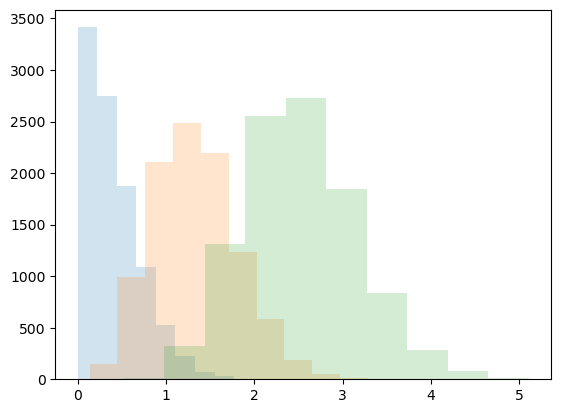

In [264]:
# distribution of major axes
plt.hist(my_eigvals[:,0]**.5,alpha=.2);
plt.hist(my_eigvals[:,1]**.5,alpha=.2);
plt.hist(my_eigvals[:,2]**.5,alpha=.2);


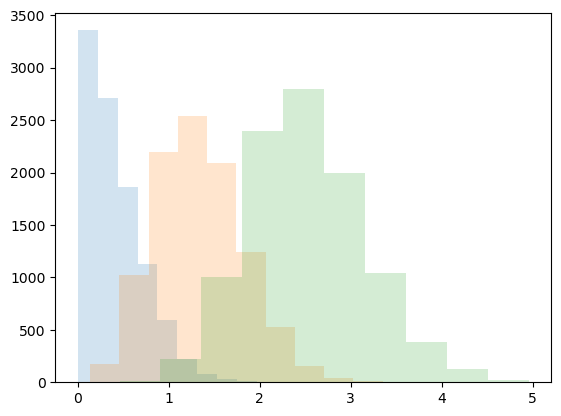

In [265]:
# distribution of major axes
plt.hist(true_eigvals[:,0]**.5,alpha=.2);
plt.hist(true_eigvals[:,1]**.5,alpha=.2);
plt.hist(true_eigvals[:,2]**.5,alpha=.2);
